In [1]:
%%writefile model/data_setup.py
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from pathlib import Path
"""
Contain for setting updata with full func to create dataloader
"""

def create_dataloader(
                    train_transform: transforms.Compose,
                    val_transform: transforms.Compose,
                    test_transform: transforms.Compose,
                    **kwargs,
                ):
    dataset_path = Path(kwargs['dataset']['dataset_path'])
    
    train_path = dataset_path / kwargs['dataset']['folder_train']
    val_path = dataset_path / kwargs['dataset']['folder_val']
    test_path = dataset_path / kwargs['dataset']['folder_test']
    
    train_data = ImageFolder(
        root= train_path,
        transform= train_transform
    )
    
    val_data = ImageFolder(
        root= val_path,
        transform= val_transform
    )

    test_data = ImageFolder(
        root= test_path,
        transform= test_transform
    )
    
    train_dataloader = DataLoader(
        dataset= train_data,
        batch_size= kwargs['dataset']['batch_size'],
        shuffle= True
    )
    
    val_dataloader = DataLoader(
        dataset= val_data,
        batch_size= kwargs['dataset']['batch_size'],
        shuffle= False
    )

    test_dataloader = DataLoader(
        dataset= test_data,
        batch_size= kwargs['dataset']['batch_size'],
        shuffle= False
    )
    class_names = train_data.classes
    return train_dataloader, val_dataloader, test_dataloader, class_names

Overwriting model/data_setup.py


In [2]:
%%writefile model/model_builder.py
import torch
from torch import nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import resnet50, ResNet50_Weights

from pathlib import Path
import json

def efficientnet_v2_s_model(class_names: None|list = None, pretrain_model_path: None|str= None, device: str= 'cpu'):
    weights = EfficientNet_V2_S_Weights.DEFAULT
    model = efficientnet_v2_s(weights= weights).to(device)

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
    )

    model = model.to(device)
    return model

def resnet50_model(class_names: None|list = None, pretrain_model_path: None|str= None, device: str= 'cpu'):
    info_data = None
    if pretrain_model_path is None:
        weights = ResNet50_Weights.DEFAULT
        model = resnet50(weights= weights).to(device)
        model.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=len(class_names), bias=True)
        )
        model = model.to(device)
        
    else:
        pretrain_model_path = Path(pretrain_model_path)

        with open(pretrain_model_path / 'info.json', 'r') as f:
            info_data = json.load(f)
        
        model = resnet50().to(device)
        model.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=len(info_data['class_names']), bias=True)
        )
        model.load_state_dict(torch.load(f=pretrain_model_path / 'model.pth'))
        model = model.to(device)
        
    return model, info_data

Overwriting model/model_builder.py


In [3]:
%%writefile model/utils.py
import os
from pathlib import Path
import torch
import json
import matplotlib.pyplot as plt
import seaborn as sns

from torchmetrics import ConfusionMatrix

def plot_loss_curves(results: dict[str, list[float]]):
    train_loss = results['train_loss']
    val_loss = results['val_loss']
    train_accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    return plt

def plot_confmat(table):
    plt.figure(figsize=(11, 8))
    sns.heatmap(table, annot=True, fmt='.0f')
    plt.title('Confusion Matrix')

    return plt

def save_model(model: torch.nn.Module,
               results: dict[str, list[float]],
               class_names: list,
               device: str):
    
    graph_loss = plot_loss_curves(results)

    confmat = ConfusionMatrix(task="multiclass", num_classes= len(class_names)).to(device)
    
    preds = torch.tensor(results['test_results']['preds']).to(device)
    target = torch.tensor(results['test_results']['target']).to(device)
    table = confmat(preds, target).tolist()
    
    graph_confmat = plot_confmat(table)
    
    target_dir = Path('runs/classify/')
    target_dir.mkdir(parents=True, exist_ok=True)
    
    model_name = 'model.pth'
    graph_loss_name = 'loss_acc.jpg'
    graph_confmat_name = 'confusion_matrix.jpg'
    info_file_name = 'info.json'
    
    train_paths = os.listdir(target_dir)
    
    i = 0
    
    while True:
        train_path = f'train{i}'
        if train_path not in train_paths:
            break
        else:
            i += 1

    target_dir = target_dir / train_path
    
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,exist_ok=True)
    
    model_save_path = target_dir_path / model_name
    graph_loss_save_path = target_dir_path / graph_loss_name
    graph_confmat_save_path = target_dir_path / graph_confmat_name
    info_save_path = target_dir_path / info_file_name
    
    print(f"[INFO] Saving model to: {target_dir}")
    
    info_data = {
        "class_names" : class_names,
        "results" : results
    }
    
    with open(info_save_path, 'w') as f:
        json.dump(info_data, f, indent=4)

    graph_loss.savefig(graph_loss_save_path)
    graph_confmat.savefig(graph_confmat_save_path)
    torch.save(obj=model.state_dict(), f=model_save_path)

Overwriting model/utils.py


In [4]:
%%writefile model/engine.py
import torch
from torchmetrics import Accuracy
from tqdm.auto import tqdm

def __train(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_func: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            mectric_func: Accuracy,
            device: str):
    
    train_loss = 0
    train_acc = 0
    
    model.train()

    for _, (X, y) in enumerate(tqdm(dataloader, desc= '-----Train')):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_func(y_pred, y)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1), dim= 1)
        train_acc += mectric_func(y_pred, y).item()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

def __val(model: torch.nn.Module,
           dataloader: torch.utils.data.DataLoader,
           loss_func: torch.nn.Module,
           mectric_func: Accuracy,
           device: str):

    val_loss = 0
    val_acc = 0
    
    model.eval()
    
    with torch.inference_mode():
        for _, (X, y) in enumerate(tqdm(dataloader, desc= '-------Val')):
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            loss = loss_func(y_pred, y)
            
            val_loss += loss.item()
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1), dim= 1)
            val_acc += mectric_func(y_pred, y).item()

        val_loss /= len(dataloader)
        val_acc /= len(dataloader)

    return val_loss, val_acc

def __test(model: torch.nn.Module,
           dataloader: torch.utils.data.DataLoader,
           device: str):
    
    model.eval()
    target = torch.tensor([]).to(device)
    preds = torch.tensor([]).to(device)
    print('\n\n')
    with torch.inference_mode():
        for _, (X, y) in enumerate(tqdm(dataloader, desc= '------Test')):
            X, y = X.to(device), y.to(device)

            
            y_pred = model(X)
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1), dim= 1)

            target = torch.cat((target, y), dim= 0)
            preds = torch.cat((preds, y_pred_class), dim= 0)

    test_results = {
        'preds' : preds.tolist(),
        'target' : target.tolist()
    }

    return test_results

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_func: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          mectric_funcs: Accuracy,
          epochs: int,
          info_data: list,
          device: str):

    if info_data is None:
        results = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_results' : {}
        }
    else:
        results = info_data['results']
    torch.manual_seed(42) 
    torch.cuda.manual_seed(42)

    for epoch in tqdm(range(epochs), desc= 'Training'):
        print(f"\n\nEpoch: {epoch+1:2} ------------")
        train_loss, train_acc = __train(model=model,
                                        dataloader=train_dataloader,
                                        loss_func=loss_func,
                                        optimizer=optimizer,
                                        mectric_func=mectric_funcs,
                                        device= device)
        
        val_loss, val_acc = __val(model=model,
                                dataloader=val_dataloader,
                                loss_func=loss_func,
                                mectric_func=mectric_funcs,
                                device= device)
        
        print(f"Epoch: {epoch+1:2} | Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.5f} | Val Acc: {val_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    results["test_results"] = __test(model=model,
                                     dataloader=test_dataloader,
                                     device= device)
    return results

Overwriting model/engine.py


In [5]:
%%writefile model/train.py
import torch
from torch import nn
from torchvision import transforms

from pathlib import Path
from torchmetrics import Accuracy, ConfusionMatrix

from model.data_setup import create_dataloader
from model.engine import train
from model.utils import save_model
from model.model_builder import resnet50_model

def run(**kwargs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: '{device}'")
    
    train_transforms_data = transforms.Compose([
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor()
    ])
    
    val_transforms_data = transforms.Compose([
        transforms.Resize(size= 224),
        transforms.ToTensor()
    ])

    test_transforms_data = transforms.Compose([
        transforms.Resize(size= 224),
        transforms.ToTensor()
    ])
    
    train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloader(**kwargs,
                                                                          train_transform=train_transforms_data,
                                                                          val_transform=val_transforms_data,
                                                                          test_transform=test_transforms_data)


    model, info_data = resnet50_model(class_names= class_names, pretrain_model_path= kwargs['train_para']['pretrain_model_path'], device= device)
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params= model.parameters(), lr= kwargs['train_para']['learning_rate'])
    
    accur = Accuracy(task='multiclass', num_classes= len(class_names)).to(device)
    
    results = train(
            model= model,
            train_dataloader= train_dataloader,
            val_dataloader= val_dataloader,
            test_dataloader= test_dataloader,
            loss_func= loss_func,
            optimizer= optimizer,
            mectric_funcs= accur,
            epochs= kwargs['train_para']['epoch'],
            info_data = info_data,
            device= device
    )
    
    save_model(model= model, results= results, class_names= class_names, device= device)

Overwriting model/train.py


Device: 'cuda'


Training:   0%|          | 0/1 [00:00<?, ?it/s]



Epoch:  1 ------------


-----Train:   0%|          | 0/32 [00:00<?, ?it/s]

-------Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch:  1 | Train Loss: 0.33747 | Train Acc: 0.8936 | Val Loss: 0.17936 | Val Acc: 0.9512





------Test:   0%|          | 0/313 [00:00<?, ?it/s]

[INFO] Saving model to: runs\classify\train5


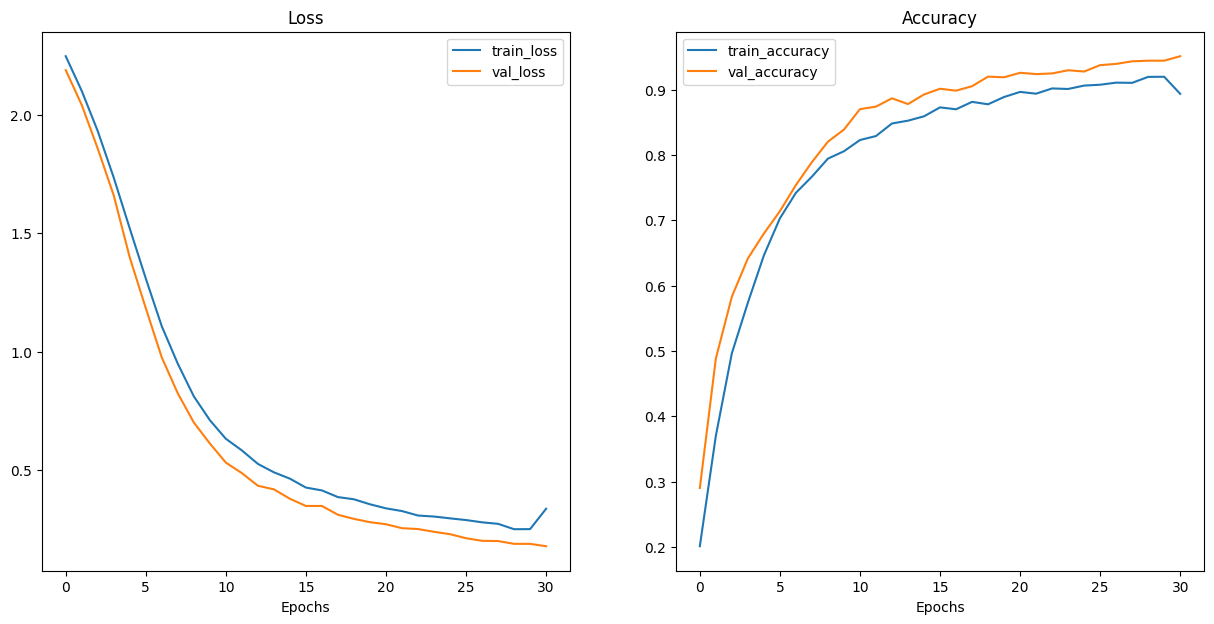

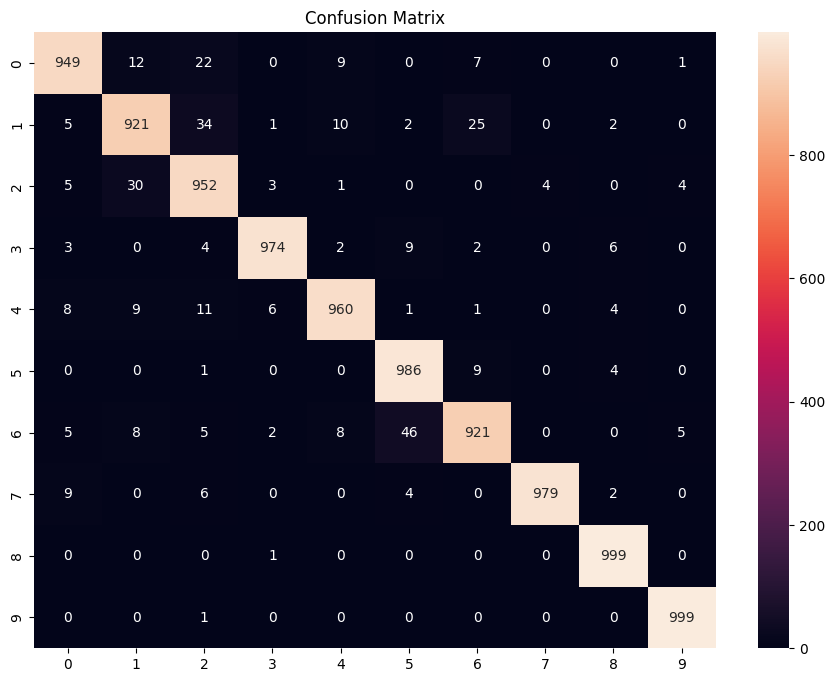

In [6]:
from model import train

config = {
    'dataset' : {
        'dataset_path':'./datasets/tomato',
        'folder_train': 'val',
        'folder_val': 'val',    
        'folder_test': 'train',
        'batch_size': 32,
    },
    'train_para': {
        'pretrain_model_path': './runs/classify/train0',
        'epoch': 1,
        'learning_rate': 0.001
    },
    'save_para': {
        'model_name': 'model.pth',
        'graph_loss_name': 'loss_acc.jpg',
        'graph_confmat_name': 'confusion_matrix.jpg',
        'info_file_name': 'info.json'
    }
}
train.run(**config)
# train.run(dataset_path='./datasets/tomato', epoch= 1, batch_size= 32)

In [108]:
# %%writefile model/disease_detection.py
import torch
from torchvision import transforms

import numpy as np
from PIL import Image
from pathlib import Path

from model.model_builder import resnet50_model

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import asyncio

class AI_model:
    def __init__(self, path_to_model: str):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.model, info_data = resnet50_model(pretrain_model_path= path_to_model)
        self.class_names = info_data['class_names']

        self.img_transform = transforms.Compose([
            transforms.Resize(size= 224),
            transforms.ToTensor()
        ])

        target_layers = [self.model.layer4[-1]]
        # self.cam = GradCAM(model=self.model, target_layers=target_layers)
        # self.cam = ScoreCAM(model=self.model, target_layers=target_layers)
        # self.cam = HiResCAM(model=self.model, target_layers=target_layers)
        # self.cam = GradCAMPlusPlus(model=self.model, target_layers=target_layers)
        self.cam = AblationCAM(model=self.model, target_layers=target_layers)
        
    async def predict(self, img: Image):   
        img_tensor = self.img_transform(img)
        img_tensor_in_batch = img_tensor.unsqueeze(dim= 0)
        
        rgb_img = img_tensor.permute(1, 2, 0).numpy()
        
        
        
        self.model.eval()
        with torch.inference_mode():
            
            
            predict = self.model(img_tensor_in_batch)
            soft_max_persent = torch.softmax(predict, dim= 1)
            predicted_class = self.class_names[torch.argmax(predict, dim= 1)]

            
            
            probability = (soft_max_persent[0, torch.argmax(predict, dim= 1)].item())
            # print(predicted_class)
            
        targets = [ClassifierOutputTarget(torch.argmax(predict, dim= 1).item())]
        grayscale_cam = self.cam(input_tensor=img_tensor_in_batch, targets= targets)
        visualization = show_cam_on_image(rgb_img, grayscale_cam[0], use_rgb=True)

        results = {
            "image" : img,
            "predicted_image" : Image.fromarray(visualization),
            "class_name" : predicted_class,
            "class_prob" : probability
        }
        return results
        

In [109]:
from PIL import Image
from pathlib import Path
import random

# from model.disease_detection import AI_model

model = AI_model(path_to_model= './runs/classify/train1')

val_path = Path('./datasets/tomato/val')
imgs = list(val_path.glob(f'*/*.JPG'))

In [ ]:
import matplotlib.pyplot as plt

random_img = random.choice(imgs)
print(random_img)
img = Image.open(random_img)
results = await model.predict(img)

plt.figure(figsize=[7, 6])
plt.subplot(1, 2, 1)
plt.imshow(results['image'])
plt.title(results['class_name'])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(results['predicted_image'])
plt.title(results['class_prob'])
plt.axis("off")

datasets\tomato\val\healthy\17010943329273842.JPG


 80%|██████████████████████████████████████████████████████████████████▏                | 51/64 [01:02<00:15,  1.23s/it]